In [52]:
import cv2
import numpy as np
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
import chromadb
import google.generativeai as genai
import os
import matplotlib.pyplot as plt
from pathlib import Path
import re
from PIL import Image
from dotenv import load_dotenv
load_dotenv()

True

In [53]:
# --- Carga de API keys desde .env ---
genai.configure(api_key=os.getenv('GEMINI_API_KEY'))

# --- Configuración de dispositivos ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Modelos para segmentación y caption ---
predictor = SAM2ImagePredictor.from_pretrained(
    "facebook/sam2-hiera-large",
    device="cpu"
)
processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip     = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

# --- Modelos para RAG+CLIP ---
# CLIP para embeddings de crop
clip_model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# MiniLM para embeddings de texto
model_text     = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device
)

# --- Cliente y colecciones Chroma ---
client    = chromadb.PersistentClient(path="chroma")
text_col  = client.get_or_create_collection(
    name="tavascan_text",
    metadata={"hnsw:space": "cosine"}
)
img_col   = client.get_or_create_collection(
    name="tavascan_images",
    metadata={"hnsw:space": "cosine"}
)

# --- Lectura de imagen ---
img_bgr = cv2.imread("C:/Users/weiha/Documents/HackUPC_2025/img/dashboard.jpeg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(img_rgb)

In [78]:
# Variables globales
ref_pt = []           # puntos de la selección (en coords de display)
drawing = False       # flag de arrastre
scale_percent = 100   # zoom inicial en porcentaje
img = img_bgr.copy()  # imagen original
h_orig, w_orig = img.shape[:2]

# Función para recalcular la imagen mostrada según el zoom
def update_display():
    global img_display, img_copy, scale
    scale = scale_percent / 100.0
    w_disp = int(w_orig * scale)
    h_disp = int(h_orig * scale)
    img_display = cv2.resize(img, (w_disp, h_disp), interpolation=cv2.INTER_AREA)
    img_copy = img_display.copy()
    # Si ya hay ref_pt, redibuja el rectángulo en img_copy
    if len(ref_pt) == 2:
        cv2.rectangle(img_copy, ref_pt[0], ref_pt[1], (0, 255, 0), 2)

# Callback para el trackbar de zoom
def on_trackbar(val):
    global scale_percent
    scale_percent = max(val, 1)  # evita 0%
    update_display()

# Callback para el mouse: dibuja y captura la caja en coords de display
def mouse_callback(event, x, y, flags, param):
    global ref_pt, drawing, img_copy
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ref_pt = [(x, y)]
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        img_copy = img_display.copy()
        cv2.rectangle(img_copy, ref_pt[0], (x, y), (0, 255, 0), 2)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        ref_pt.append((x, y))
        img_copy = img_display.copy()
        cv2.rectangle(img_copy, ref_pt[0], ref_pt[1], (0, 255, 0), 2)
        # Mapea coords de display a coords originales
        x0_disp, y0_disp = ref_pt[0]
        x1_disp, y1_disp = ref_pt[1]
        x0 = int(x0_disp / scale)
        y0 = int(y0_disp / scale)
        x1 = int(x1_disp / scale)
        y1 = int(y1_disp / scale)
        print(f"Coordenadas en imagen original: ({x0},{y0}) → ({x1},{y1})")

# Prepara la ventana y los callbacks
update_display()
cv2.namedWindow("Selector de caja")
cv2.createTrackbar("Zoom %", "Selector de caja", scale_percent, 300, on_trackbar)
cv2.setMouseCallback("Selector de caja", mouse_callback)

# Bucle de visualización
while True:
    cv2.imshow("Selector de caja", img_copy)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("r"):       # 'r' resetea la selección
        ref_pt = []
        img_copy = img_display.copy()
    elif key == ord("q"):     # 'q' sale
        break

cv2.destroyAllWindows()

Coordenadas en imagen original: (1212,60) → (1408,219)


In [82]:
# tras el bucle y antes de usar predictor:
x0_disp, y0_disp = ref_pt[0]
x1_disp, y1_disp = ref_pt[1]

# Asegura que (x0_disp,y0_disp) sea la esquina superior-izquierda
x0_disp, x1_disp = sorted([x0_disp, x1_disp])
y0_disp, y1_disp = sorted([y0_disp, y1_disp])

# Mapea a coordenadas de la imagen original y clampa
x0 = int(x0_disp / scale)
y0 = int(y0_disp / scale)
x1 = int(x1_disp / scale)
y1 = int(y1_disp / scale)

# Evita salirse de los límites
x0 = max(0, min(x0, w_orig - 1))
y0 = max(0, min(y0, h_orig - 1))
x1 = max(1, min(x1, w_orig    ))
y1 = max(1, min(y1, h_orig    ))

# -----------------------------------------------------------------------

# boxleft = 492
# boxtop = 116
# boxwidth = 150
# boxheight = 69

# x0 = boxleft
# y0 = boxtop
# x1 = boxleft + boxwidth
# y1 = boxtop + boxheight

box = np.array([[x0, y0, x1, y1]], dtype=np.int32)

with torch.inference_mode():
    masks, scores, logits = predictor.predict(
        box=box,
        multimask_output=False,
        return_logits=True
    )

mask = masks[0]
crop = img_rgb[y0:y1, x0:x1]

# convierte de RGB a BGR para cv2
crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
cv2.imshow("Region seleccionada", crop_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [83]:
# --- RAG+CLIP retrieval with enhanced specific description ---
# 1) Embedding of the region with CLIP (for image collection)
inputs_img = clip_processor(images=crop, return_tensors="pt").to(device)
with torch.no_grad():
    img_emb = clip_model.get_image_features(**inputs_img)
    img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
img_emb = img_emb.cpu().numpy()[0]

# 1b) Text embedding based on a specific and technical description of the image
# Option 1: Improve BLIP with more specific conditioning text
text = "This part of the CUPRA Tavascan dashboard is:"  # Specific conditioning text
inputs_blip = processor_blip(
    images=crop,
    text=text,  # Add conditional text to guide the description
    return_tensors="pt"
).to(device)
with torch.no_grad():
    out = model_blip.generate(
        **inputs_blip,
        max_length=50,  # Allow longer descriptions
        num_beams=5,    # Beam search for better quality
        temperature=0.7 # Creativity control
    )
    blip_description = processor_blip.decode(out[0], skip_special_tokens=True)

# Option 2: Use Gemini to get a more technical and precise description
crop_pil = Image.fromarray(crop)
description_prompt = """
Specifically describe this component of the CUPRA Tavascan dashboard.
Include:
- Exact technical name of the component
- Its specific location on the dashboard
- Distinctive visual characteristics (shape, color, symbols)
- Type of control or indicator it appears to be
Respond concisely in 1-2 technical sentences.
"""

try:
    # If Gemini API key is available and working
    model = genai.GenerativeModel('gemini-2.0-flash-001')
    gemini_response = model.generate_content([description_prompt, crop_pil])
    gemini_description = gemini_response.text.strip()

    # Combine both descriptions for greater specificity
    image_description = f"{blip_description} {gemini_description}"
    print(f"Combined specific description: {image_description}")
except Exception as e:
    # Fallback to BLIP if Gemini fails
    image_description = f"{blip_description} Control or indicator on the CUPRA Tavascan dashboard."
    print(f"BLIP description (fallback): {image_description}")

# Generate text embedding to query text_col
text_embedding = model_text.encode([image_description], normalize_embeddings=True)[0]

# 2) Query to text collection with the enhanced description
top_k = 5  # Total results to show

# Query the text collection using the TEXT embedding
txt_hits = text_col.query(
    query_embeddings=[text_embedding.tolist()],
    n_results=top_k*2,
    include=["documents", "metadatas", "distances"]
)

# 3) Process results using only text score
combined_results = []

# First, we inspect a result to see what fields the metadata actually has
print("\n--- Available metadata example ---")
if txt_hits["metadatas"] and len(txt_hits["metadatas"][0]) > 0:
    sample_meta = txt_hits["metadatas"][0][0]
    print(f"Available fields: {list(sample_meta.keys())}")
    print(f"Complete example: {sample_meta}")

    # FUNCTION TO EXTRACT PAGE WITH DETAILED INSPECTION
    def extract_page_info(metadata, text=None):
        """
        Extracts page information with detailed inspection and text usage
        Includes more potential sources of page information
        """
        # 1. Look in common metadata fields
        page_fields = ["page", "start_page", "page_num", "page_number", "pagina", "page_id"]
        for field in page_fields:
            if field in metadata and metadata[field]:
                return f"p.{metadata[field]}"

        # 2. Search all metadata fields for anything that looks like a page
        for key, value in metadata.items():
            if isinstance(value, str):
                # Look for patterns like "page 23", "p.45", etc.
                page_patterns = [
                    r"page\s*(\d+)",
                    r"p\.?\s*(\d+)",
                    r"pagina\s*(\d+)",
                    r"pág\.?\s*(\d+)"
                ]
                for pattern in page_patterns:
                    match = re.search(pattern, value, re.IGNORECASE)
                    if match:
                        return f"p.{match.group(1)}"

        # 3. Look in file paths or sources
        source_fields = ["source", "path", "file", "filename", "filepath"]
        for field in source_fields:
            if field in metadata and metadata[field]:
                source_str = metadata[field]
                match = re.search(r"page[_-]?(\d+)", source_str, re.IGNORECASE)
                if match:
                    return f"p.{match.group(1)}"

        # 4. Try to extract page from text if available
        if text:
            # Look for page mentions in text
            text_patterns = [
                r"page\s*(\d+)",
                r"p\.?\s*(\d+)",
                r"page number[:\s]*(\d+)",
                r"fig\.?\s+\w+\s+on\s+page\s+(\d+)"
            ]
            for pattern in text_patterns:
                match = re.search(pattern, text, re.IGNORECASE)
                if match:
                    return f"p.{match.group(1)}"

        return "p.N/A"  # If no page information is found

    # Process results using only text score
    if txt_hits["documents"] and len(txt_hits["documents"][0]) > 0:
        for i, (doc, meta, distance) in enumerate(zip(
            txt_hits["documents"][0],
            txt_hits["metadatas"][0],
            txt_hits["distances"][0]
        )):
            # Convert distance to similarity (1 = very similar, 0 = not similar)
            text_score = 1.0 - float(distance)

            # Add relevance bonus if it contains important keywords
            # based on the specific description
            keywords = ["indicator", "panel", "board", "dashboard", "control", "instrument",
                       "digital", "cockpit", "display", "screen"]

            # Extract possible specific keywords from the description
            specific_keywords = [word.lower() for word in image_description.split()
                               if len(word) > 3 and word.lower() not in
                               ["this", "that", "cupra", "tavascan", "for", "like", "part"]]

            keywords.extend(specific_keywords)

            # Calculate relevance boost based on keywords
            relevance_boost = 0.0
            for keyword in keywords:
                if keyword.lower() in doc.lower():
                    relevance_boost += 0.05  # 5% boost for each keyword found

            # Apply boost with a 20% maximum
            boosted_score = min(text_score + relevance_boost, 1.0)

            # Extract page information using the improved function
            page_info = extract_page_info(meta, doc)

            # Create result with boosted score
            result = {
                "id": f"txt_{i}",
                "text": doc,
                "metadata": meta,
                "text_score": boosted_score,
                "page_info": page_info,
                "combined_score": boosted_score,
                "keywords_found": [k for k in keywords if k.lower() in doc.lower()]
            }

            combined_results.append(result)

# Sort by text score
combined_results.sort(key=lambda x: x["text_score"], reverse=True)
combined_results = combined_results[:top_k]  # Keep only the best ones

# 4) Build context with results
context_items = []
for i, result in enumerate(combined_results):
    page_info = result["page_info"]
    score_info = f"(relevance: {result['text_score']:.2f})"

    # Include found keywords for better context
    keywords_info = ""
    if result.get("keywords_found"):
        keywords_info = f" [Keywords: {', '.join(result['keywords_found'][:3])}]"

    context_items.append(f"- {result['text']} {page_info} {score_info}{keywords_info}")

context_txt = "\n".join(context_items)

# 5) Enhanced RAG prompt with specific description
prompt = (
    f"You are an expert on the CUPRA Tavascan manual.\n"
    f"The image shows: {image_description}\n\n"
    f"Relevant information from the manual (ordered by relevance):\n{context_txt}\n\n"
    f"What exactly is the component selected in the image? Describe its:\n"
    f"- Specific technical name\n"
    f"- Main and secondary function\n"
    f"- How it is used or interacted with\n"
    f"- Where it is located in the vehicle\n\n"
    f"Answer with technical precision based solely on the information from the manual."
)

# 6) Gemini call including the image
model = genai.GenerativeModel('gemini-2.0-flash-001')
crop_pil = Image.fromarray(crop)
response = model.generate_content([prompt, crop_pil])
print("\nRAG Response with specific description:\n")
print(response.text)

# Show used fragments
print("\n--- Fragments used (sorted by relevance) ---")
for i, result in enumerate(combined_results):
    print(f"{i+1}. Text score: {result['text_score']:.4f}")
    print(f"   Text: {result['text'][:100]}..." if len(result['text']) > 100 else f"   Text: {result['text']}")
    print(f"   Extracted page: {result['page_info']}")
    if result.get("keywords_found"):
        print(f"   Keywords found: {', '.join(result['keywords_found'])}")

    # Show detailed metadata information for debugging
    print("   Available metadata:")
    for key, value in result["metadata"].items():
        if value:  # Only show fields with values
            print(f"      - {key}: {value}")
    print()

Combined specific description: this part of the cupra tavascan dashboard is :'s only available in the cupra ta ta ta ta ta ta ta is ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta Here's a description of the component:

This is an *Air Vent*, specifically the *passenger-side dashboard air vent*. It is trapezoidal in shape with horizontal vanes, black in color, and is encased in a bronze/copper colored trim, appearing to be a manually adjustable directional airflow control.

--- Available metadata example ---
Available fields: ['section_title', 'start_page', 'chunk_index', 'section_id']
Complete example: {'section_title': 'NOTICE', 'start_page': 339, 'chunk_index': 0, 'section_id': '3ce30d57-be86-4382-b591-a8eca85dca27'}

RAG Response with specific description:

Based on the provided manual excerpts, I can identify related information, but I can't pinpoint all the specifics of the component in the image. Here's what I can infer:

*   **Specific Technical Name:** The manua

Buscando imágenes similares a 'this part of the cupra tavascan dashboard is :'s only available in the cupra ta ta ta ta ta ta ta is ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta ta Here's a description of the component:

This is an *Air Vent*, specifically the *passenger-side dashboard air vent*. It is trapezoidal in shape with horizontal vanes, black in color, and is encased in a bronze/copper colored trim, appearing to be a manually adjustable directional airflow control.'
Configuración: 0.60 similitud visual + 0.40 relevancia textual
Calculando embedding visual con CLIP...
Calculando embedding de texto con SentenceTransformer...
Reutilizando resultados de texto de la consulta anterior...
Caché de scores de texto disponible para 5 documentos
Precalculando resultados de texto más similares...
Analizando 221 imágenes...


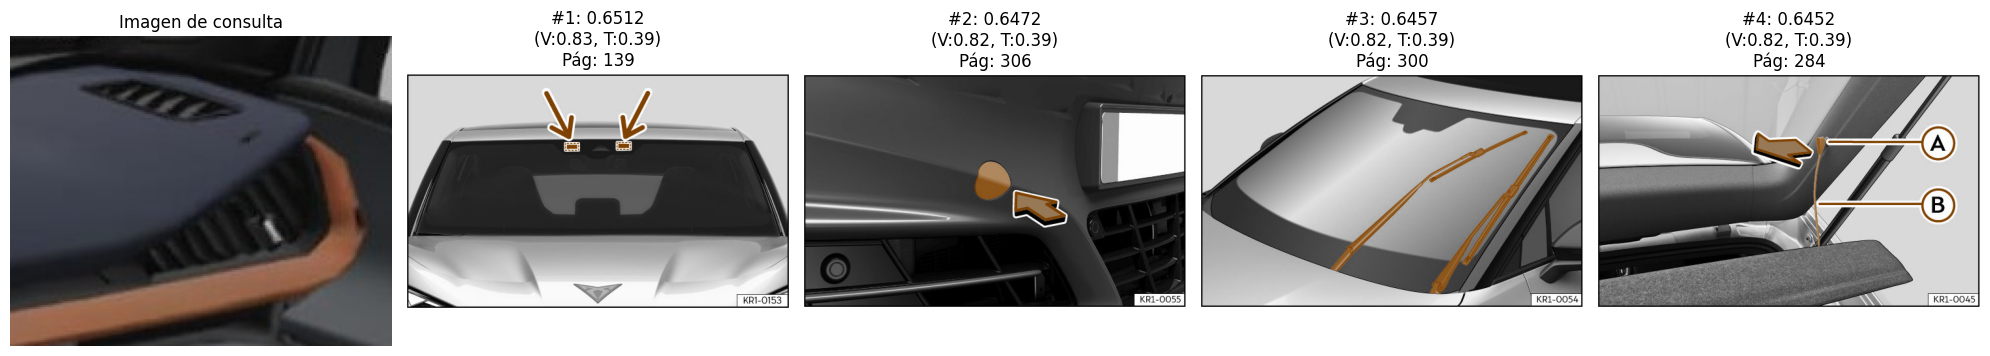


====== TOP 10 IMÁGENES MÁS SIMILARES ======
#   SCORE      VISUAL     TEXTO      PÁGINA   ARCHIVO
1   0.651191 0.828600 0.385076 139      page_139_img_2.jpeg
    Texto relacionado: CUPRA accepts no liability for any damage to the vehicle caused either by inadequate workshop servic...
2   0.647238 0.822013 0.385076 306      page_306_img_1.jpeg
    Texto relacionado: CUPRA accepts no liability for any damage to the vehicle caused either by inadequate workshop servic...
3   0.645747 0.819527 0.385076 300      page_300_img_2.jpeg
    Texto relacionado: CUPRA accepts no liability for any damage to the vehicle caused either by inadequate workshop servic...
4   0.645236 0.818676 0.385076 284      page_284_img_1.jpeg
    Texto relacionado: CUPRA accepts no liability for any damage to the vehicle caused either by inadequate workshop servic...
5   0.644917 0.818144 0.385076 307      page_307_img_2.jpeg
    Texto relacionado: CUPRA accepts no liability for any damage to the vehicle caused either

[{'path': 'C:\\Users\\weiha\\Documents\\HackUPC_2025\\extracted_content_manual\\images\\page_139_img_2.jpeg',
  'image': <PIL.Image.Image image mode=RGB size=585x358>,
  'visual_score': 0.8286004066467285,
  'text_score': 0.38507604598999023,
  'combined_score': 0.6511906623840332,
  'metadata': {'chunk_index': 0,
   'section_title': 'NOTICE',
   'start_page': 339,
   'section_id': '3ce30d57-be86-4382-b591-a8eca85dca27'},
  'filename': 'page_139_img_2.jpeg',
  'page': '139',
  'related_text': 'CUPRA accepts no liability for any damage to the vehicle caused either by inadequate workshop servic...'},
 {'path': 'C:\\Users\\weiha\\Documents\\HackUPC_2025\\extracted_content_manual\\images\\page_306_img_1.jpeg',
  'image': <PIL.Image.Image image mode=RGB size=586x355>,
  'visual_score': 0.8220134377479553,
  'text_score': 0.38507604598999023,
  'combined_score': 0.6472384810447692,
  'metadata': {'chunk_index': 0,
   'section_title': 'NOTICE',
   'start_page': 339,
   'section_id': '3ce30d57

In [84]:
# Directorio de imágenes del manual
images_folder = "C:/Users/weiha/Documents/HackUPC_2025/extracted_content_manual/images"

def rank_similar_images_combined(input_image, description, top_k=10, visual_weight=0.6, text_weight=0.4):
    """
    Ranking de imágenes por similitud visual y textual combinadas con extracción mejorada de metadatos
    aprovechando scores previos y optimizando consultas
    
    Args:
        input_image: Imagen de consulta (numpy array)
        description: Descripción textual de la imagen
        top_k: Número de resultados a mostrar
        visual_weight: Peso para la similitud visual (0-1)
        text_weight: Peso para la similitud textual (0-1)
    """
    # Declarar acceso a la variable global al inicio de la función
    global combined_results

    # Función mejorada para extraer página de cualquier fuente de información
    def extract_page_info(text=None, metadata=None, filename=None):
        """Extrae número de página de múltiples fuentes posibles"""
        # 1. Buscar en metadatos si están disponibles
        if metadata:
            # Campos comunes de página
            page_fields = ["page", "start_page", "page_num", "page_number", "pagina", "page_id"]
            for field in page_fields:
                if field in metadata and metadata[field]:
                    return f"{metadata[field]}"

            # Buscar en cualquier campo de metadatos
            for key, value in metadata.items():
                if isinstance(value, str):
                    # Patrones como "page 23", "p.45", etc.
                    page_patterns = [
                        r"page\s*(\d+)",
                        r"p\.?\s*(\d+)",
                        r"pagina\s*(\d+)",
                        r"pág\.?\s*(\d+)"
                    ]
                    for pattern in page_patterns:
                        match = re.search(pattern, value, re.IGNORECASE)
                        if match:
                            return match.group(1)

        # 2. Buscar en el nombre de archivo
        if filename:
            # Patrones comunes en nombres de archivo
            page_patterns = [
                r"page[_-]?(\d+)",
                r"p(\d+)",
                r"_(\d+)\.(?:jpe?g|png)$"  # Números antes de la extensión
            ]
            for pattern in page_patterns:
                match = re.search(pattern, filename, re.IGNORECASE)
                if match:
                    return match.group(1)

        # 3. Buscar en el texto si está disponible
        if text:
            text_patterns = [
                r"page\s*(\d+)",
                r"p\.?\s*(\d+)",
                r"page number[:\s]*(\d+)",
                r"fig\.?\s+\w+\s+on\s+page\s+(\d+)"
            ]
            for pattern in text_patterns:
                match = re.search(pattern, text, re.IGNORECASE)
                if match:
                    return match.group(1)

        return "N/A"

    # Normalizar pesos para que sumen 1
    total = visual_weight + text_weight
    visual_weight = visual_weight / total
    text_weight = text_weight / total

    print(f"Buscando imágenes similares a '{description}'")
    print(f"Configuración: {visual_weight:.2f} similitud visual + {text_weight:.2f} relevancia textual")

    # 1. Obtener embedding visual con CLIP
    print("Calculando embedding visual con CLIP...")
    inputs_img = clip_processor(images=input_image, return_tensors="pt").to(device)
    with torch.no_grad():
        visual_emb = clip_model.get_image_features(**inputs_img)
        visual_emb = visual_emb / visual_emb.norm(p=2, dim=-1, keepdim=True)
    visual_emb = visual_emb.cpu().numpy()[0]

    # 2. Obtener embedding textual con SentenceTransformer
    print("Calculando embedding de texto con SentenceTransformer...")
    text_emb = model_text.encode([description], normalize_embeddings=True)[0]

    # 3. OPTIMIZACIÓN: Reutilizar resultados de texto si ya existen en el contexto global
    text_scores_cache = {}
    if 'combined_results' in globals() and combined_results is not None and len(combined_results) > 0:
        print("Reutilizando resultados de texto de la consulta anterior...")

        # Extraer scores y metadatos de resultados previos
        for result in combined_results:
            if 'text_score' in result and 'metadata' in result and 'text' in result:
                key = result.get('text', '')[:50]  # Usar inicio del texto como clave
                if key:
                    text_scores_cache[key] = {
                        'score': result['text_score'],
                        'metadata': result['metadata'],
                        'text': result['text']
                    }

        print(f"Caché de scores de texto disponible para {len(text_scores_cache)} documentos")
    else:
        text_scores_cache = {}

    # 4. Obtener textos relacionados solo si no hay caché suficiente
    if len(text_scores_cache) < 30:  # Si tenemos menos de 30 resultados en caché, consultar
        print("Precalculando resultados de texto más similares...")
        general_text_matches = text_col.query(
            query_embeddings=[text_emb.tolist()],
            n_results=50,
            include=["documents", "metadatas", "distances"]
        )

        # Crear un mapa de página -> mejores resultados para búsquedas rápidas
        page_to_text_results = {}
        if general_text_matches["documents"] and len(general_text_matches["documents"][0]) > 0:
            for i, (doc, meta, distance) in enumerate(zip(
                general_text_matches["documents"][0],
                general_text_matches["metadatas"][0],
                general_text_matches["distances"][0]
            )):
                text_score = 1.0 - float(distance)

                # Añadir a la caché para futuras consultas
                key = doc[:50]
                text_scores_cache[key] = {
                    'score': text_score,
                    'metadata': meta,
                    'text': doc
                }

                # Extraer página del texto/metadatos
                extracted_page = extract_page_info(text=doc, metadata=meta)

                if extracted_page != "N/A":
                    if extracted_page not in page_to_text_results:
                        page_to_text_results[extracted_page] = []

                    page_to_text_results[extracted_page].append({
                        "doc": doc,
                        "meta": meta,
                        "score": text_score
                    })
    else:
        # Usar la caché para crear el mapeo de página a resultados
        page_to_text_results = {}
        for key, item in text_scores_cache.items():
            doc = item['text']
            meta = item['metadata']
            text_score = item['score']

            extracted_page = extract_page_info(text=doc, metadata=meta)
            if extracted_page != "N/A":
                if extracted_page not in page_to_text_results:
                    page_to_text_results[extracted_page] = []

                page_to_text_results[extracted_page].append({
                    "doc": doc,
                    "meta": meta,
                    "score": text_score
                })

    # 5. Buscar similitudes visuales y textuales para cada imagen
    image_paths = list(Path(images_folder).glob("*.jpeg")) + \
                  list(Path(images_folder).glob("*.jpg")) + \
                  list(Path(images_folder).glob("*.png"))

    # Asegurar que hay imágenes para procesar
    if not image_paths:
        print(f"No se encontraron imágenes en {images_folder}")
        return []

    # OPTIMIZACIÓN: Caché para similitudes visuales
    visual_sim_cache = {}

    print(f"Analizando {len(image_paths)} imágenes...")

    # 6. Procesar cada imagen y calcular scores combinados
    combined_scores = []
    processed_count = 0

    for img_path in image_paths:
        try:
            img_name = os.path.basename(img_path)
            processed_count += 1

            # 6.1 Similitud visual con CLIP
            # Comprobar si ya tenemos esta similitud en caché
            if str(img_path) in visual_sim_cache:
                visual_similarity = visual_sim_cache[str(img_path)]
            else:
                img = Image.open(img_path).convert("RGB")
                inputs = clip_processor(images=img, return_tensors="pt").to(device)
                with torch.no_grad():
                    img_emb = clip_model.get_image_features(**inputs)
                    img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
                img_emb_np = img_emb.cpu().numpy()[0]

                # Calcular similitud visual (producto punto)
                visual_similarity = float(np.dot(visual_emb, img_emb_np))

                # Guardar en caché para futuras consultas
                visual_sim_cache[str(img_path)] = visual_similarity

            # 6.2 Extraer información y número de página del nombre del archivo
            page_num = extract_page_info(filename=img_name)

            # 6.3 Similitud textual - buscar texto relacionado usando nuestros resultados precalculados
            text_similarity = 0.0
            metadata_info = {}
            related_text = ""

            if page_num != "N/A" and page_num in page_to_text_results:
                # Usar la mejor similitud de texto para esta página
                best_match = max(page_to_text_results[page_num], key=lambda x: x["score"])
                text_similarity = best_match["score"]
                metadata_info = best_match["meta"]
                related_text = best_match["doc"]

                # Aplicar boost de relevancia por keyword matching
                keywords = ["indicador", "panel", "tablero", "dashboard", "control", "instrumento",
                           "digital", "cockpit", "display", "pantalla"]

                # Extraer palabras clave específicas de la descripción
                specific_keywords = [word.lower() for word in description.split()
                                   if len(word) > 3 and word.lower() not in
                                   ["esta", "este", "cupra", "tavascan", "para", "como", "part"]]

                keywords.extend(specific_keywords)

                # Calcular bonus por palabras clave
                relevance_boost = 0.0
                for keyword in keywords:
                    if keyword.lower() in related_text.lower():
                        relevance_boost += 0.02  # 2% boost por palabra clave

                # Aplicar boost con máximo de 15%
                text_similarity = min(text_similarity + relevance_boost, 1.0)
            else:
                # Si no hay match exacto por página, usar texto general basado en similitud con la descripción
                best_score = 0.0
                for key, item in text_scores_cache.items():
                    if item['score'] > best_score:
                        best_score = item['score']
                        metadata_info = item['metadata']
                        related_text = item['text']

                if best_score > 0:
                    text_similarity = best_score

                    # Si no teníamos página, intentar extraerla del texto
                    if page_num == "N/A":
                        page_from_text = extract_page_info(text=related_text, metadata=metadata_info)
                        if page_from_text != "N/A":
                            page_num = page_from_text

            # 6.4 Calcular score combinado
            combined_score = (visual_weight * visual_similarity) + (text_weight * text_similarity)

            # 6.5 Añadir a resultados
            combined_scores.append({
                "path": str(img_path),
                "image": img,
                "visual_score": float(visual_similarity),
                "text_score": float(text_similarity),
                "combined_score": float(combined_score),
                "metadata": metadata_info,
                "filename": img_name,
                "page": page_num,
                "related_text": related_text[:100] + "..." if len(related_text) > 100 else related_text
            })

        except Exception as e:
            print(f"Error procesando {img_path}: {e}")

    # 7. Ordenar por puntuación combinada
    combined_scores.sort(key=lambda x: x["combined_score"], reverse=True)
    top_results = combined_scores[:top_k]

    # 8. Visualizar resultados
    n_cols = 5
    n_rows = (min(top_k, len(combined_scores)) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if top_k == 1 else axes

    # Mostrar la imagen de consulta en la primera posición
    axes[0].imshow(input_image)
    axes[0].set_title("Imagen de consulta")
    axes[0].axis("off")

    # Mostrar el resto de resultados
    for i, result in enumerate(top_results):
        if i >= len(axes) - 1:  # -1 porque la primera es la consulta
            break

        axes[i+1].imshow(result["image"])
        axes[i+1].set_title(f"#{i+1}: {result['combined_score']:.4f}\n" +
                           f"(V:{result['visual_score']:.2f}, T:{result['text_score']:.2f})\nPág: {result['page']}")
        axes[i+1].axis("off")

    # Ocultar ejes vacíos
    for i in range(len(top_results) + 1, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    # 9. Mostrar tabla de resultados detallada
    print("\n====== TOP 10 IMÁGENES MÁS SIMILARES ======")
    print(f"{'#':<3} {'SCORE':<10} {'VISUAL':<10} {'TEXTO':<10} {'PÁGINA':<8} {'ARCHIVO'}")
    print("="*70)

    for i, result in enumerate(top_results):
        print(f"{i+1:<3} {result['combined_score']:.6f} {result['visual_score']:.6f} "
             f"{result['text_score']:.6f} {result['page']:<8} {result['filename']}")

        # Mostrar texto relacionado si existe
        if result["related_text"]:
            print(f"    Texto relacionado: {result['related_text']}")

    # Guardar los resultados en una variable global para reutilización
    combined_results = top_results

    return top_results

# Llamar a la función de ranking de imágenes similares
rank_similar_images_combined(crop, image_description, top_k=5)